In [186]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_size=(800, 1000)):
  '''Resize the image while maintaining aspect ratio'''
  h, w = image.shape[:2]
  scale = min(target_size[1] / w, target_size[0] / h)
  new_w = int(w * scale)
  new_h = int(h * scale)
  resized_image = cv2.resize(image, (new_w, new_h))
  return resized_image

def logarithmic_transformation(image, epsilon=1e-5):
  '''Apply logarithmic transformation to the image with zero value handling'''
  c = 255 / np.log(1 + np.max(image))
  # Epsilon zero-handling technique
  log_image = c * (np.log(1 + image + epsilon))
  log_image = np.array(log_image, dtype=np.uint8)

  return log_image

def contrast_stretching(image):
  min_val = np.min(image)
  max_val = np.max(image)
  stretched = (image - min_val) * (255 / (max_val - min_val))
  return stretched.astype(np.uint8)

def gaussian_blur(image, mode='Soft'):
  if mode == 'Soft':
    kernel_size = (3,3)
  elif mode == 'Medium':
    kernel_size = (5,5)
  elif mode == 'Hard':
    kernel_size = (7,7)
  else:
    raise ValueError("Mode must be 'Soft', 'Medium', or 'Hard'")

  return cv2.GaussianBlur(image, kernel_size, 0)

def measure_blurriness(image):
  # Apply the Laplacian operator to detect edges
  laplacian = cv2.Laplacian(image, cv2.CV_64F)
  # Variance of Laplacian
  variance = laplacian.var()

  return variance

def adaptive_gaussian_blur(image, desired_blur=100, max_iterations=100):
  # Measure initial blur level
  initial_blur = measure_blurriness(image)

  # Set a starting kernel size
  kernel_size = 5

  for iteration in range(max_iterations):
      # Apply Gaussian blur with the current kernel size
      blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

      # Measure the blur after applying Gaussian blur
      current_blur = measure_blurriness(blurred_image)

      # If the current blur exceeds the desired blur, stop
      if current_blur > desired_blur:
          kernel_size += 2
      else:
        break

  final_blurred_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
  final_blur = measure_blurriness(final_blurred_img)

  print(f"Initial Blur: {initial_blur}, Final Blur: {final_blur}, Kernel Size: {kernel_size}, Iterations: {iteration+1}")

  return final_blurred_img

def clahe_equalization(image):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equalized_img = clahe.apply(image)
  return equalized_img

def otsu_thresholding(image):
  _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  return binary_image

def canny_edge_detection(image, low_threshold=50, high_threshold=150):
  return cv2.Canny(image, low_threshold, high_threshold)

def find_extreme_corners(contours):
  '''Find the extreme corners of the image'''
  all_points = np.vstack(contours)
  top_left = all_points[np.argmin(all_points[:, :, 0] + all_points[:, :, 1])]
  bottom_right = all_points[np.argmax(all_points[:, :, 0] + all_points[:, :, 1])]
  top_right = all_points[np.argmax(all_points[:, :, 0] - all_points[:, :, 1])]
  bottom_left = all_points[np.argmin(all_points[:, :, 0] - all_points[:, :, 1])]
  return top_left[0], top_right[0], bottom_left[0], bottom_right[0]

def apply_perspective_transformation(image, corners):
  '''Apply perspective transformation to the image'''
  tl, tr, bl, br = corners
  width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
  height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

  dst_pts = np.array([
      [0, 0],
      [width - 1, 0],
      [0, height - 1],
      [width - 1, height - 1]
  ], dtype="float32")

  src_pts = np.array([tl, tr, bl, br], dtype="float32")

  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(image, M, (width, height))
  return warped

def automatic_warp_transformation(image, target_size=(800, 1000)):
  '''Automatic Cropping using Adaptive Warp Transformation'''
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  resized_image = resize_image(gray_image, target_size)
  brightened_image = logarithmic_transformation(resized_image)
  contrast_image = contrast_stretching(brightened_image)
  blurred_image = gaussian_blur(contrast_image, mode='Soft')
  binary_image = otsu_thresholding(blurred_image)
  edges = canny_edge_detection(binary_image)
  contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Getting Contours (Drawing Contours in image, useful for debugging)
  contour_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
  cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

  corners = find_extreme_corners(contours)
  for corner in corners:
      cv2.circle(contour_image, tuple(corner), 5, (0, 0, 255), -1)

  warped_image = apply_perspective_transformation(resized_image, corners)
  print(f'Initial image {image.shape} processed to {warped_image.shape}')

  return warped_image

def image_uniformization(master_image, student_image):
  '''Precision Image Resizing'''
  master_shape = master_image.shape
  student_shape = student_image.shape

  master_height = master_shape[0]
  master_width = master_shape[1]

  student_height = student_shape[0]
  student_width = student_shape[1]

  min_height = min(master_height, student_height)
  min_width = min(master_width, student_width)

  resized_master = cv2.resize(master_image, (min_width, min_height))
  resized_student = cv2.resize(student_image, (min_width, min_height))

  print(f'master_key {master_image.shape} and student_answer {student_image.shape} uniformed to {resized_master.shape}')

  return resized_master, resized_student

def morph_open(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  eroded_img = cv2.erode(image, kernel, iterations = 1)
  dilated_img = cv2.dilate(eroded_img, kernel, iterations = 1)

  return dilated_img

def core_preprocessing(image):
  '''Core Preprocessing Module'''
  blurred_img = gaussian_blur(image, mode='Hard')
  contrast_img = contrast_stretching(blurred_img)
  log_img = logarithmic_transformation(contrast_img)
  binary_img = otsu_thresholding(log_img)
  opened_img = morph_open(binary_img)

  return opened_img

def core_preprocessing_v2(image):
  '''
  Core Preprocessing Module V2:
  - Uses CLAHE for lighting handling
  - Uses Adaptive Gaussian Blur to ensure optimal thresholding
  '''
  clahe_img = clahe_equalization(image)
  blurred_img = adaptive_gaussian_blur(clahe_img, desired_blur=100, max_iterations=100)
  contrast_img = contrast_stretching(blurred_img)
  log_img = logarithmic_transformation(contrast_img)
  binary_img = otsu_thresholding(log_img)
  opened_img = morph_open(binary_img)

  return opened_img

def draw_full_contours(contours, cont_image, radius = 7):
  '''Draw Full Circles'''
  for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      # Draw a filled circle at the center of the contour
      cv2.circle(cont_image, (cX, cY), radius, (0, 255, 0), -1)

  return cont_image

def extract_and_draw_contours(image):
  contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  unique_values = []
  for columns in image:
    for pixel in columns:
      if pixel not in unique_values:
        unique_values.append(pixel)

  contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  contour_image = draw_full_contours(contours, contour_image)

  return contours, contour_image

def extract_and_draw_circle_contours(image):
  contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  circle_contours = []
  contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  # radius_list = []
  # contour_ar_list = []

  for contour in contours:
      # Approximate the enclosing circle for each contour
      (x, y), radius = cv2.minEnclosingCircle(contour)
      circle_area = np.pi * (radius ** 2)

      # if radius not in radius_list:
      #   radius_list.append(radius)

      # if contour_area not in contour_ar_list:
      #   contour_ar_list.append(contour_area)

      # Calculate the actual contour area
      contour_area = cv2.contourArea(contour)

      # Check if the contour area is approximately equal to the circle area
      # Tolerance range for being "circular"
      if radius < 5:
          if 0.6 <= contour_area / circle_area <= 1.4:
              circle_contours.append(contour)
      else:
          if 0.8 <= contour_area / circle_area <= 1.2:
              circle_contours.append(contour)

  # contour_image = cv2.drawContours(contour_image, circle_contours, -1, (0, 255, 0), thickness=2)
  contour_image = draw_full_contours(circle_contours, contour_image)

  return circle_contours, contour_image

def soft_morph_open(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  eroded_img = cv2.erode(image, kernel, iterations = 1)
  dilated_img = cv2.dilate(eroded_img, kernel, iterations = 1)

  return dilated_img

def final_scoring(new_student, processed_student, master_contours):
  '''Final Score Calculation'''
  test_answer = processed_student.copy()
  # drawing the Answer Key to the Student's test answer, extracting the mistakes information
  check_answers = draw_full_contours(master_contours, test_answer)

  # open the image to remove noise
  final_sheet = soft_morph_open(check_answers)

  # fetching mistakes contours
  final_contours, img = extract_and_draw_circle_contours(final_sheet)
  
  # calculating mistakes and final score
  mistakes = len(final_contours)
  total_questions = len(master_contours)
  print(f'total_questions: {total_questions}, mistakes: {mistakes}')
  final_score = ((total_questions - mistakes) / total_questions) * 100
  print(f'final score: {final_score}')

  student_correction = cv2.cvtColor(new_student, cv2.COLOR_GRAY2BGR)
  student_correction = draw_full_contours(master_contours, student_correction)

  return final_score, student_correction

In [187]:
answer1 = cv2.imread('inputs/circle_1/stu_good_light.jpg')
master_sheet = cv2.imread('inputs/circle_1/master_circle_best.jpg')

# answer1 = cv2.imread('inputs/circle_2/student1_crop.jpg')
# master_sheet = cv2.imread('inputs/circle_2/master1_crop.jpg')

# print(master_sheet.shape)
# # MASTER KEY
# gray_img = cv2.cvtColor(master_sheet, cv2.COLOR_BGR2GRAY)

# plt.figure(figsize = (10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(master_sheet, cmap='gray')
# plt.title('Ori image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(gray_img, cmap='gray')
# plt.title('Gray img')
# plt.axis('off')

# plt.show()

In [188]:
# resized = resize_image(gray_img)
# log_img = logarithmic_transformation(resized)
# contrast_img = contrast_stretching(log_img)
# blurred_img = gaussian_blur(contrast_img)
# # blurred_img = adaptive_gaussian_blur(contrast_img)
# binary_img = otsu_thresholding(blurred_img)

# plt.figure(figsize = (30, 20))

# plt.subplot(1, 5, 1)
# plt.imshow(resized, cmap='gray')
# plt.title('resized')
# plt.axis('off')

# plt.subplot(1, 5, 2)
# plt.imshow(log_img, cmap='gray')
# plt.title('log img')
# plt.axis('off')

# plt.subplot(1, 5, 3)
# plt.imshow(contrast_img, cmap='gray')
# plt.title('cont image')
# plt.axis('off')

# plt.subplot(1, 5, 4)
# plt.imshow(blurred_img, cmap='gray')
# plt.title('blurred img')
# plt.axis('off')

# plt.subplot(1, 5, 5)
# plt.imshow(binary_img, cmap='gray')
# plt.title('thresh image')
# plt.axis('off')

# plt.show()

In [189]:
# blurriness = measure_blurriness(blurred_img)
# print('Blurriness: ', blurriness)

In [190]:
student1 = automatic_warp_transformation(answer1)
master_key = automatic_warp_transformation(master_sheet)

print(f'master_sheet {master_sheet.shape} processed to {master_key.shape}')
print(f'answer1 {answer1.shape} processed to {student1.shape}')

# plt.figure(figsize = (10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(master_key, cmap='gray')
# plt.title('Master Key')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(student1, cmap='gray')
# plt.title('Student Answer')
# plt.axis('off')

# plt.show()

Initial image (3839, 1036, 3) processed to (776, 188)
Initial image (3832, 1021, 3) processed to (781, 189)
master_sheet (3832, 1021, 3) processed to (781, 189)
answer1 (3839, 1036, 3) processed to (776, 188)


In [191]:
new_master, new_student = image_uniformization(master_key, student1)
print(new_master.shape, new_student.shape)

master_key (781, 189) and student_answer (776, 188) uniformed to (776, 188)
(776, 188) (776, 188)


In [192]:
# def histogram_equalization(image):
#   equalized_img = cv2.equalizeHist(image)
#   return equalized_img

# eq_img = histogram_equalization(new_student)
# clahe_img = clahe_equalization(new_student)

# plt.figure(figsize = (15, 10))

# plt.subplot(3, 1, 1)
# plt.imshow(new_student, cmap='gray')
# plt.title('new_student')
# plt.axis('off')

# plt.subplot(3, 1, 2)
# plt.imshow(eq_img, cmap='gray')
# plt.title('eq_img')
# plt.axis('off')

# plt.subplot(3, 1, 3)
# plt.imshow(clahe_img, cmap='gray')
# plt.title('clahe_img')
# plt.axis('off')

# plt.show()

In [193]:
# clahe_img = clahe_equalization(new_master)
# blurred_img = gaussian_blur(clahe_img, mode='Hard')
# contrast_img = contrast_stretching(blurred_img)
# log_img = logarithmic_transformation(contrast_img)
# binary_img = otsu_thresholding(log_img)

# plt.figure(figsize=(15, 25))

# plt.subplot(6, 1, 1)
# plt.imshow(new_master, cmap='gray')
# plt.title('new_master')
# plt.axis('off')

# plt.subplot(6, 1, 2)
# plt.imshow(clahe_img, cmap='gray')
# plt.title('clahe_img')
# plt.axis('off')

# plt.subplot(6, 1, 3)
# plt.imshow(blurred_img, cmap='gray')
# plt.title('blurred img')
# plt.axis('off')

# plt.subplot(6, 1, 4)
# plt.imshow(contrast_img, cmap='gray')
# plt.title('cont image')
# plt.axis('off')

# plt.subplot(6, 1, 5)
# plt.imshow(log_img, cmap='gray')
# plt.title('log img')
# plt.axis('off')

# plt.subplot(6, 1, 6)
# plt.imshow(binary_img, cmap='gray')
# plt.title('thresh image')
# plt.axis('off')

# plt.show()

# blurriness = measure_blurriness(blurred_img)
# print('Blurriness: ', blurriness)

In [194]:
# # Example pipeline with improved adaptive Gaussian blur
# clahe_img = clahe_equalization(new_master)
# blurred_img = adaptive_gaussian_blur(clahe_img, desired_blur=100, max_iterations=100)
# contrast_img = contrast_stretching(blurred_img)
# log_img = logarithmic_transformation(contrast_img)
# binary_img = otsu_thresholding(log_img)


# plt.figure(figsize=(15, 25))

# plt.subplot(6, 1, 1)
# plt.imshow(new_master, cmap='gray')
# plt.title('new_master')
# plt.axis('off')

# plt.subplot(6, 1, 2)
# plt.imshow(clahe_img, cmap='gray')
# plt.title('clahe_img')
# plt.axis('off')

# plt.subplot(6, 1, 3)
# plt.imshow(blurred_img, cmap='gray')
# plt.title('blurred img')
# plt.axis('off')

# plt.subplot(6, 1, 4)
# plt.imshow(contrast_img, cmap='gray')
# plt.title('cont image')
# plt.axis('off')

# plt.subplot(6, 1, 5)
# plt.imshow(log_img, cmap='gray')
# plt.title('log img')
# plt.axis('off')

# plt.subplot(6, 1, 6)
# plt.imshow(binary_img, cmap='gray')
# plt.title('thresh image')
# plt.axis('off')

# plt.show()

# blurriness = measure_blurriness(blurred_img)
# print('Blurriness: ', blurriness)

In [195]:
# cv2_imshow(new_master)

In [196]:
# cv2_imshow(new_student)

In [197]:
processed_master = core_preprocessing_v2(new_master)
processed_student = core_preprocessing_v2(new_student)

# plt.figure(figsize = (15, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(processed_master, cmap='gray')
# plt.title('Master Key')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(processed_student, cmap='gray')
# plt.title('Student Answer')
# plt.axis('off')

# plt.show()

Initial Blur: 7563.028356815565, Final Blur: 81.03814921412811, Kernel Size: 9, Iterations: 3
Initial Blur: 12594.605205433561, Final Blur: 76.90097086772752, Kernel Size: 9, Iterations: 3


In [198]:
# cv2_imshow(processed_student)

In [199]:
student_contours, student_contour_image = extract_and_draw_contours(processed_student)
master_contours, master_contour_image = extract_and_draw_contours(processed_master)

print(len(student_contours))
print(len(master_contours))

# plt.figure(figsize = (10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(master_contour_image, cmap='gray')
# plt.title('Master Key')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(student_contour_image, cmap='gray')
# plt.title('Student Answer')
# plt.axis('off')

# plt.show()

100
100


In [200]:
# cv2_imshow(master_contour_image)

In [201]:
print(student_contour_image.shape, master_contour_image.shape)

(776, 188, 3) (776, 188, 3)


In [202]:
# test_answer = processed_student.copy()
# # check_answers = cv2.drawContours(test_answer, master_contours, -1, (0, 255, 0), 7)
# check_answers = draw_full_contours(master_contours, processed_student)

# plt.figure(figsize = (10, 5))

# plt.imshow(check_answers, cmap='gray')
# plt.title('Check Answers')
# plt.axis('off')

# plt.show()

total_questions: 100, mistakes: 14
final score: 86.0


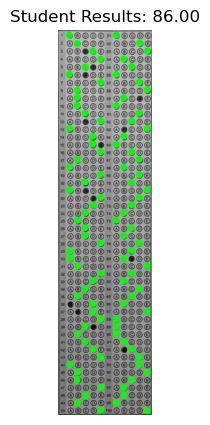

In [203]:
stu_final_score, stu_answer_key = final_scoring(new_student, processed_student, master_contours)
# cv2_imshow(stu_answer_key)

plt.figure(figsize = (10, 5))

plt.imshow(stu_answer_key, cmap='gray')
plt.title(f'Student Results: {"{:.2f}".format(stu_final_score)}')
plt.axis('off')

plt.show()

In [209]:
# answer1 = cv2.imread('inputs/circle_1/stu_good_light.jpg')
# master_sheet = cv2.imread('inputs/circle_1/master_circle_best.jpg')

answer1 = cv2.imread('inputs/circle_2/student1_crop.jpg')
master_sheet = cv2.imread('inputs/circle_2/master1_crop.jpg')

def circles_pipeline(answer_key, student_answer): 
    student_sheet = automatic_warp_transformation(student_answer)
    master_key = automatic_warp_transformation(answer_key)
    new_master, new_student = image_uniformization(master_key, student_sheet)
    processed_master = core_preprocessing_v2(new_master)
    processed_student = core_preprocessing_v2(new_student)
    student_contours, student_contour_image = extract_and_draw_contours(processed_student)
    master_contours, master_contour_image = extract_and_draw_contours(processed_master)
    stu_final_score, stu_answer_key = final_scoring(new_student, processed_student, master_contours)
    
    return stu_final_score, stu_answer_key
    
student_final_score, student_mistakes = circles_pipeline(master_sheet, answer1)

Initial image (810, 2731, 3) processed to (295, 977)
Initial image (794, 2703, 3) processed to (291, 974)
master_key (291, 974) and student_answer (295, 977) uniformed to (291, 974)
Initial Blur: 3564.0861691289438, Final Blur: 59.248868623219415, Kernel Size: 9, Iterations: 3
Initial Blur: 2308.801620248059, Final Blur: 63.77951807826636, Kernel Size: 9, Iterations: 3
total_questions: 61, mistakes: 7
final score: 88.52459016393442
